In [ ]:
import numpy as np
# load one of the saved files
loaded_data = np.load('/home/kyuan/RadarPulse/dataset/pilot_1115/train/1110_ultraseat_amit_r1.npz', allow_pickle=True)

# print the keys of the loaded file
print(loaded_data['head_data'].shape, loaded_data['head_label'].shape)
print(loaded_data['head_data'].dtype, loaded_data['head_label'].dtype)
# print the data and label shapes
# print(loaded_data['head'].shape, loaded_data['head_label'].shape)
# print(loaded_data['heart'].shape, loaded_data['heart_label'].shape)
# print(loaded_data['wrist'].shape, loaded_data['wrist_label'].shape)


(38, 5000, 4, 19) (38, 5000, 1)
complex128 int64


# Training pipeline

100%|██████████| 64/64 [00:02<00:00, 23.86it/s]


heart Data shape:  torch.Size([2432, 5000, 42]) Label shape:  torch.Size([2432, 5000, 1])
torch.Size([5000, 42]) torch.Size([5000, 1])


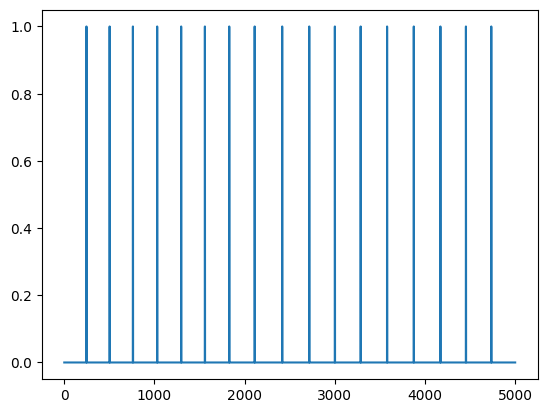

In [1]:
from src.data.dataset import PulseDataset
import matplotlib.pyplot as plt
trainset = PulseDataset('/home/kyuan/RadarPulse/dataset/phase1_1212/train', 'heart')
data, label = trainset[0]
print(data.shape, label.shape)

plt.plot(label)

In [1]:
from src.config.config_utils import load_config
config = load_config('src/config')

In [2]:
from src.data.datamodule import PulseDataModule
data_module = PulseDataModule(
    data_path=config.data.data_path,
    pulse_position=config.data.position,
    batch_size=config.training.batch_size,
    num_workers=config.training.num_workers
)
data_module.setup(stage='fit')

Setting up training dataset


100%|██████████| 58/58 [00:27<00:00,  2.09it/s]


heart Data shape:  torch.Size([2204, 5000, 42]) Label shape:  torch.Size([2204, 5000, 1])
Setting up validation dataset


100%|██████████| 58/58 [00:08<00:00,  7.20it/s]


heart Data shape:  torch.Size([406, 5000, 42]) Label shape:  torch.Size([406, 5000, 1])


In [3]:
from src.models.lightning_model import LitModel
for batch in data_module.train_dataloader():
    n_channels = batch[0].shape[2]
    break
model = LitModel(config, n_channels)

In [4]:
from pytorch_lightning.utilities.model_summary import ModelSummary
summary = ModelSummary(model, max_depth=2)
print(summary)

  | Name                 | Type              | Params
-----------------------------------------------------------
0 | model                | PulseDetectionNet | 2.7 M 
1 | model.encoder_blocks | ModuleList        | 651 K 
2 | model.lstm           | LSTM              | 790 K 
3 | model.decoder_blocks | ModuleList        | 1.2 M 
4 | model.final          | Sequential        | 3.2 K 
5 | criterion            | PulseLoss         | 0     
-----------------------------------------------------------
2.7 M     Trainable params
0         Non-trainable params
2.7 M     Total params
10.778    Total estimated model params size (MB)


In [5]:
import pytorch_lightning as pl
trainer = pl.Trainer(
    max_epochs=config.training.max_epochs,
    accelerator='auto',
    devices='auto',
    logger=None,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kyuan/anaconda3/envs/torch310/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [6]:
trainer.fit(model, data_module)

You are using a CUDA device ('NVIDIA GeForce RTX 3080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Setting up training dataset


100%|██████████| 58/58 [00:14<00:00,  4.14it/s]


heart Data shape:  torch.Size([2204, 5000, 42]) Label shape:  torch.Size([2204, 5000, 1])
Setting up validation dataset


100%|██████████| 58/58 [00:07<00:00,  7.33it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


heart Data shape:  torch.Size([406, 5000, 42]) Label shape:  torch.Size([406, 5000, 1])



  | Name      | Type              | Params
------------------------------------------------
0 | model     | PulseDetectionNet | 2.7 M 
1 | criterion | PulseLoss         | 0     
------------------------------------------------
2.7 M     Trainable params
0         Non-trainable params
2.7 M     Total params
10.778    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/kyuan/anaconda3/envs/torch310/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (34) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/home/kyuan/anaconda3/envs/torch310/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


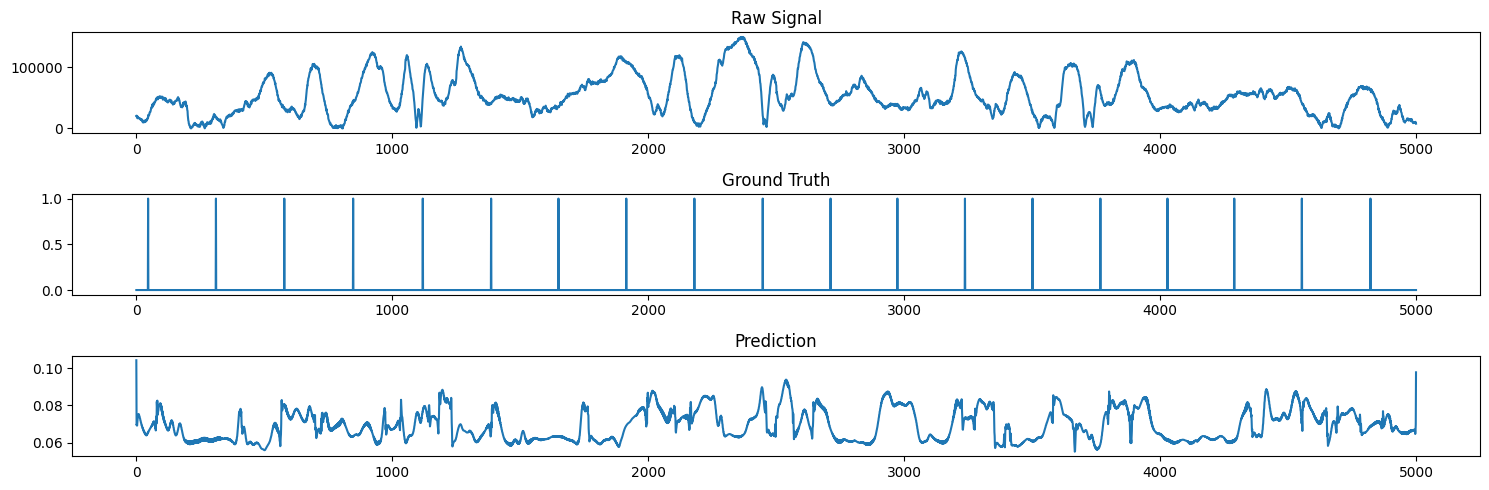

In [12]:
import matplotlib.pyplot as plt
import numpy as np
# Get validation batch and make predictions
for batch in data_module.val_dataloader():
    heart_data = batch[0].to(model.device)  # Move to GPU if available
    heart_label = batch[1].to(model.device)
    break

# with torch.no_grad():
heart_pred = model(heart_data)

# Convert to numpy for plotting
heart_data = heart_data[0].cpu().detach().numpy()  # First sample in batch
heart_label = heart_label[0].cpu().detach().numpy()
heart_pred = heart_pred[0].cpu().detach().numpy()

# Plot results
plt.figure(figsize=(15, 5))
plt.subplot(311)
plt.plot(np.abs(heart_data[:, 0]))  # Plot magnitude of first channel
plt.title('Raw Signal')

plt.subplot(312)
plt.plot(heart_label)
plt.title('Ground Truth')

plt.subplot(313)
plt.plot(heart_pred)
plt.title('Prediction')
plt.tight_layout()
plt.show()